In [49]:
# Imports
import json
import numpy as np
from operator import itemgetter, attrgetter, methodcaller
import re
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
%matplotlib inline
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt


In [50]:
# Paths
base_dir = "../.."
# results_file = base_dir + "/tmp/model_v4.3_data_testdlas96629/predictions.json"
# gensample_actuals = base_dir + "/data/gensample_hdf5_files/test_96629_10000.json"

# 4.3 dr5
    # False positive count: [1643], >20.3: [1628]
    # false negative count: [29], >20.3 [21]
    # mean col density diff: [-0.025777]
    # RMSE: [0.169069],
# results_file = base_dir + "/tmp/model_v4.3_data_dr5/predictions.json"
# gensample_actuals = base_dir + "/data/dr5_ground_truth.json"

# results_file = base_dir + "/tmp/model_v4.3_data_genmix23559/predictions.json"
# gensample_actuals = base_dir + "/data/gensample_hdf5_files/test_mix_23559_10000.json"

# results_file = base_dir + "/tmp/model_v5.1.0_data_dr5/predictions.json"
# gensample_actuals = base_dir + "/data/dr5_ground_truth.json"

# 5.1.0 dlas+slls - test mix
    # False positive count: [1712], >20.3: [144]
    # false negative count: [623], >20.3 [27]
    # mean col density diff: [0.057265]
    # RMSE: [0.209752]
# results_file = base_dir + "/tmp/model_v5.1.0_data_genmix23559/predictions.json"
# gensample_actuals = base_dir + "/data/gensample_hdf5_files/test_mix_23559_10000.json"

# 5.1.0 dlas+slls - test dla's 5k - 
    # False positive count: [1345], >20.3: [150]
    # false negative count: [54]
    # mean col density diff: [-0.057324]
    # RMSE: [0.174990]
# results_file = base_dir + "/tmp/model_v5.1.0_data_gendla96451/predictions.json"
# gensample_actuals = base_dir + "/data/gensample_hdf5_files/test_96451_5000.json"

# 4.4.1 dlas+slls - test dla's 5k
    # False positive count: [285], >20.3: [281]
    # false negative count: [74]
    # mean col density diff: [-0.008394]
    # RMSE: [0.141163]
# results_file = base_dir + "/tmp/model_v4.4.1_data_dlas5k96451/predictions.json"
# gensample_actuals = base_dir + "/data/gensample_hdf5_files/test_96451_5000.json"

# results_file = base_dir + "/tmp/model_v7.1.1_data_testdlas5k96451/predictions.json"
# gensample_actuals = base_dir + "/data/gensample_hdf5_files/test_dlas_96451_5000.json"

# results_file = base_dir + "/tmp/model_v7.1.1_data_testdlas10k96629/predictions.json"
# gensample_actuals = base_dir + "/data/gensample_hdf5_files/test_dlas_96629_10000.json"

results_file = base_dir + "/tmp/model_v7.1.1_data_dr5/predictions.json"
gensample_actuals = base_dir + "/data/dr5_ground_truth.json"


In [51]:
# Read JSON files
with open(results_file,'r') as rf, open(gensample_actuals,'r') as gs:
    predictions = sorted(json.load(rf), key=itemgetter('id'))
    actuals = json.load(gs)

In [52]:
#
# Validation function that finds FP and FN in a single prediction and actual sightline.
#

EPSILON = 0.015   # Amount of error in the DLA Z value between prediction and actual, +-0.0037 ~= +-10px

def validate_sightline(prediction, actual):
    false_positives = []
    false_negatives = []
    col_density_error = []
    offset_error = []
    
    # Check each predicted DLA against all actual DLAs for false_positives and for col_density error
    for pred_dla in prediction['dlas']:
        dla_z = pred_dla['z_dla']
        matches = False
        for act_dla_ix in range(0, actual['nDLA']):
            act_dla = actual[str(act_dla_ix)]
            if abs(dla_z - act_dla['zabs']) < EPSILON:
                matches = True
                col_density_error.append((act_dla['NHI'], pred_dla['column_density'] - act_dla['NHI'], pred_dla['column_density'], act_dla['NHI'] - pred_dla['column_density']))
                offset_error.append((act_dla['NHI'], abs(pred_dla['z_dla']-act_dla['zabs'])))
        if not matches:
            false_positives.append(pred_dla)
        
    # Check each actual DLA against all predicted DLAs for false_negatives
    for act_dla_ix in range(0, actual['nDLA']):
        act_dla = actual[str(act_dla_ix)]
        matches = False
        for pred_dla in prediction['dlas']:
            dla_z = pred_dla['z_dla']
            if abs(dla_z - act_dla['zabs']) < EPSILON and pred_dla['type'] != "LYB":
                matches = True
        if not matches and act_dla['NHI'] >= 20.30:
            false_negatives.append(act_dla)

    return false_positives, false_negatives, col_density_error, offset_error

# ix = 5
# validate_sightline(results[ix], gensample[str(ix)])

# Count of False Positives, False Negatives and Column Density stats

In [53]:
# List misclassified results
all_false_positives = []
all_false_negatives = []
all_coldensity_diff = []
all_offset_error = []

for i in range(0,len(actuals)):
    fp, fn, cd, oe = validate_sightline(predictions[i], actuals[str(i)])
#     if i == 441:
#         print json.dumps(predictions[i], indent=1), "\n---------\n", json.dumps(actuals[str(i)], indent=1), "\n---------\n", json.dumps(fp, indent=1), "\n---------\n", fn, "\n---------\n", cd, "\n---------\n", oe, "\n\n\n"
    all_offset_error.extend(oe)
    for f in fp:
        f['id'] = predictions[i]['id']
        f['z_qso'] = predictions[i]['z_qso']
    for f in fn:
        f['id'] = i
        f['sl'] = actuals[str(i)]['sl']
    all_false_positives.extend(fp)
    all_false_negatives.extend(fn)
    all_coldensity_diff.extend(cd)

all_coldensity_matrix = np.vstack(all_coldensity_diff)
mean_col_density = np.mean(all_coldensity_matrix[:,1])
rmse_col_density = np.sqrt(np.mean(np.array(all_coldensity_matrix[:,1])**2))
std_col_density = np.std(all_coldensity_matrix[:,1])

print "False positive count: [%d], >20.3: [%d]\nFalse negative count: [%d], >20.3 [%d]\nmean col density diff: [%02f]\nRMSE: [%02f],\nStd: [%02f]\n" %\
    (len(all_false_positives),
     len([fp for fp in all_false_positives if fp['type'] == 'DLA']),
     len(all_false_negatives),
     len([fn for fn in all_false_negatives if fn['NHI'] >= 20.3]),
     mean_col_density, 
     rmse_col_density, 
     std_col_density)

False positive count: [3450], >20.3: [946]
False negative count: [30], >20.3 [30]
mean col density diff: [0.010521]
RMSE: [0.215920],
Std: [0.215663]



# Plot column density error for all matching DLAs

(-1.2, 1.2)

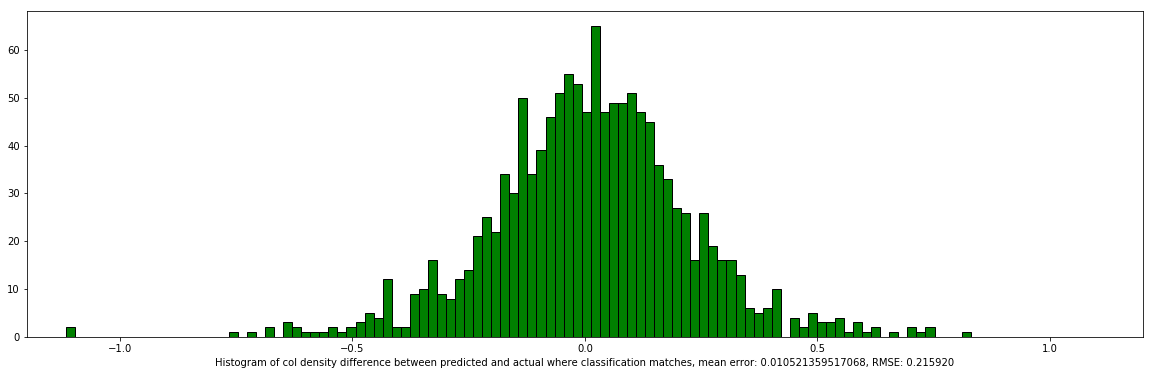

In [54]:
plt.figure(figsize=(20, 6))
plt.hist(all_coldensity_matrix[:,1], 100, facecolor='green', edgecolor='k');
plt.xlabel("Histogram of col density difference between predicted and actual where classification matches, " + \
           "mean error: %0.15f, RMSE: %0.6f" % (mean_col_density, rmse_col_density))
plt.xlim([-1.2,1.2])

# Column density with outliers removed (1.5 times IQR)

Mean [0.010521], IQR [0.254180], Q75 [0.138717], Q25 [-0.115464]
40 outliers of 1275 total samples, inliers 1235

[-1.115922366116169683891712338663637638092041015625
 -1.1099627670346450258875847794115543365478515625
 -0.761380670205941356698531308211386203765869140625
 -0.715379769776927076918582315556704998016357421875
 -0.682856898705761494738908368162810802459716796875
 -0.674211002984321794428979046642780303955078125
 -0.64783832438833854894255637191236019134521484375
 -0.6438410851111910915278713218867778778076171875
 -0.63762807127210407998063601553440093994140625
 -0.6271964955144397890762775205075740814208984375
 -0.6228602407172587618333636783063411712646484375
 -0.603891671734228197010452277027070522308349609375
 -0.57892957354562213367898948490619659423828125
 -0.555200235171344758100531180389225482940673828125
 -0.54846998961729553911936818622052669525146484375
 -0.5389389783753841811630991287529468536376953125
 -0.520551303845412149939875234849750995635986328125
 -0.5076

(-1.2, 1.2)

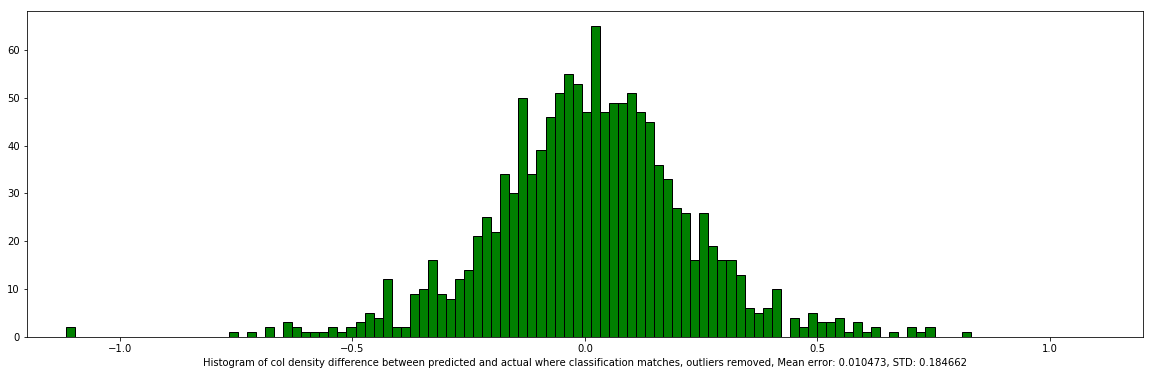

In [55]:
m = np.mean(all_coldensity_matrix[:,1])
q75, q25 = np.percentile(all_coldensity_matrix[:,1], [75 ,25])
iqr = q75 - q25
print "Mean [%f], IQR [%f], Q75 [%f], Q25 [%f]" % (m, iqr, q75, q25)

outliers = np.logical_or(all_coldensity_matrix[:,1] < q25 - 1.5*iqr, all_coldensity_matrix[:,1] > q75 + 1.5*iqr)
inliers = np.logical_not(outliers)
print "%d outliers of %d total samples, inliers %d\n" % (np.sum(outliers), all_coldensity_matrix[:,1].shape[0], np.sum(inliers))
print np.sort(all_coldensity_matrix[:,1][outliers])

mean_col_density_outliersremoved = np.mean(all_coldensity_matrix[inliers,1])
std_col_density_outliersremoved = np.std(all_coldensity_matrix[inliers,1])
plt.figure(figsize=(20, 6))
plt.hist(all_coldensity_matrix[:,1], 100, facecolor='green', edgecolor='k');
plt.xlabel("Histogram of col density difference between predicted and actual where classification matches, outliers removed, " + \
           "Mean error: %06f, STD: %06f" % (mean_col_density_outliersremoved, std_col_density_outliersremoved))
plt.xlim([-1.2,1.2])

# Plot column density error for a range column densities

[19.2, 19.3] (0, 2) nan nan
[19.3, 19.4] (0, 2) nan nan
[19.4, 19.5] (0, 2) nan nan
[19.5, 19.6] (0, 2) nan nan
[19.6, 19.7] (0, 2) nan nan
[19.7, 19.8] (0, 2) nan nan
[19.8, 19.9] (6, 2) 0.295009854583 0.126542150091
[19.9, 20.0] (33, 2) 0.0163663994733 0.189980993096
[20.0, 20.1] (66, 2) -0.00658420157255 0.217173728235
[20.1, 20.2] (73, 2) -0.035357466599 0.274467975398
[20.2, 20.3] (94, 2) 0.0167927376026 0.194800196201
[20.3, 20.4] (139, 2) 0.0527462623941 0.192905655043
[20.4, 20.5] (168, 2) 0.0324149474926 0.168658818159
[20.5, 20.6] (193, 2) 0.0277686671799 0.189128674648
[20.6, 20.7] (148, 2) 0.00217316213495 0.213725025434
[20.7, 20.8] (108, 2) 0.0122775136005 0.237090393311
[20.8, 20.9] (80, 2) -0.0514245547057 0.23553858195
[20.9, 21.1] (93, 2) -0.0390802700329 0.266113631
[21.1, 21.4] (57, 2) 0.00177038580524 0.236306618673
[21.4, 21.7] (15, 2) 0.0333050910064 0.144988524749
[21.7, 22.5] (2, 2) -0.0473673217756 0.0763660556963
[  -0.016196774248477558560965761103    1.0657

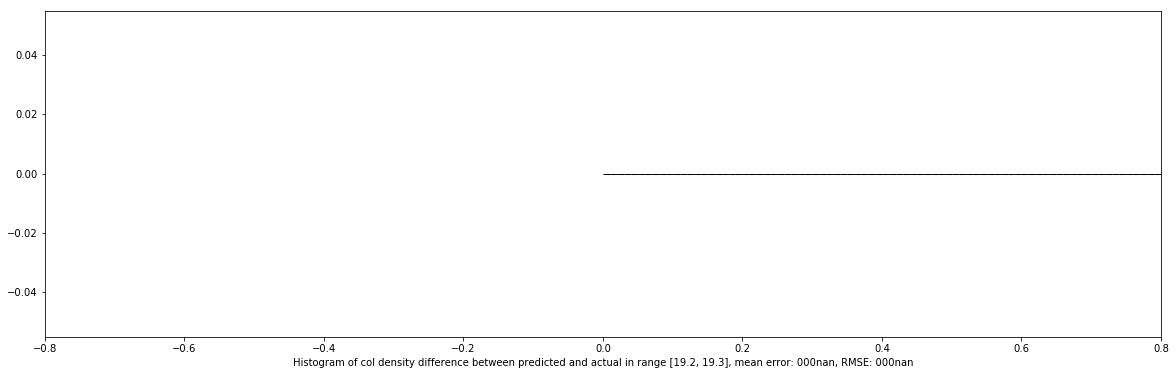

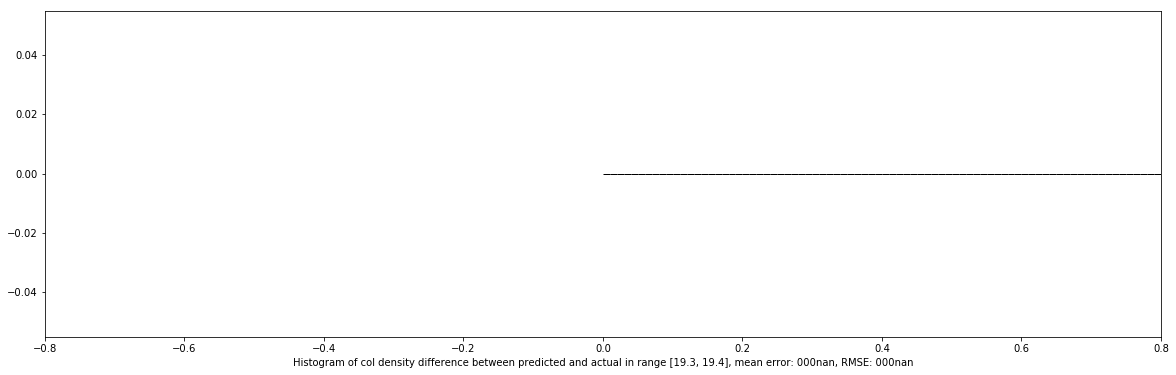

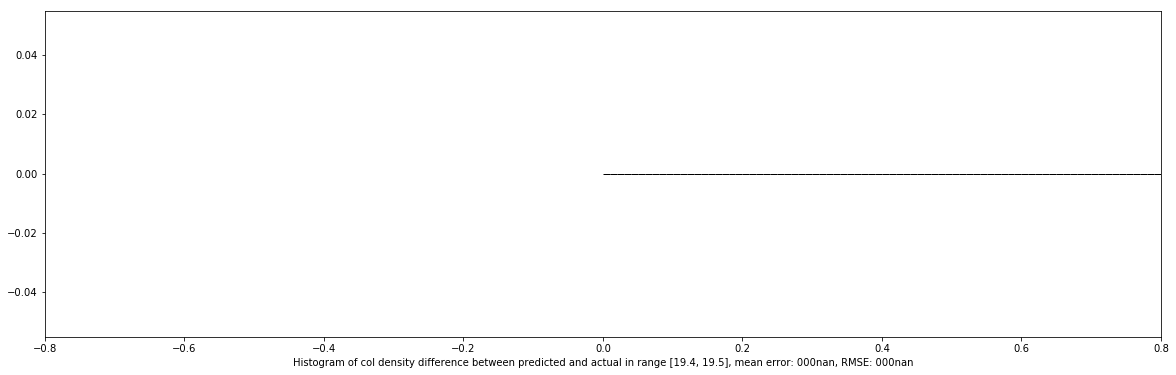

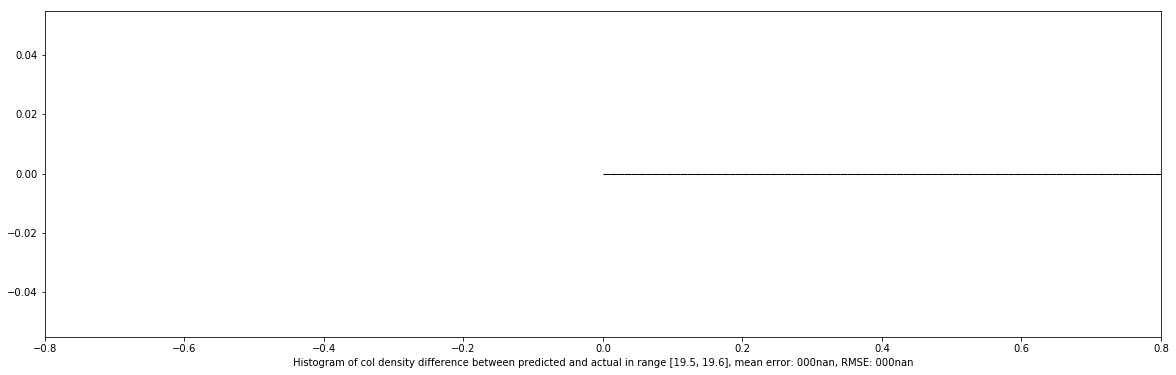

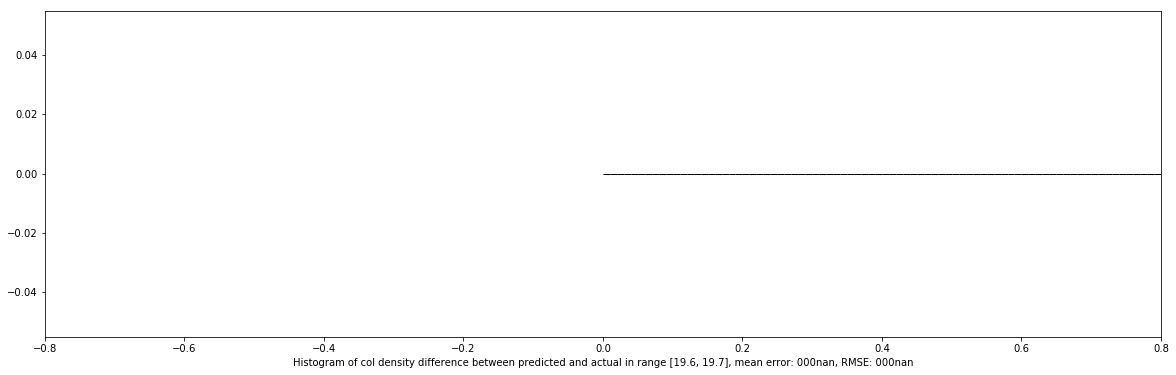

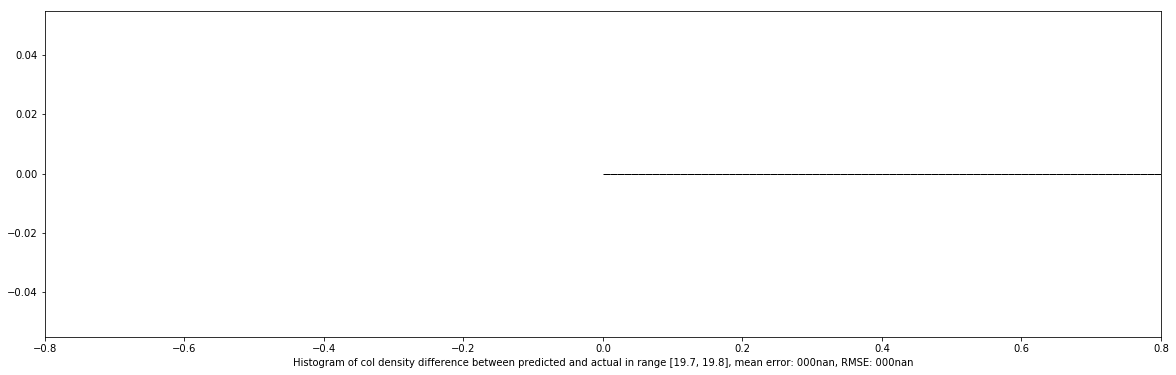

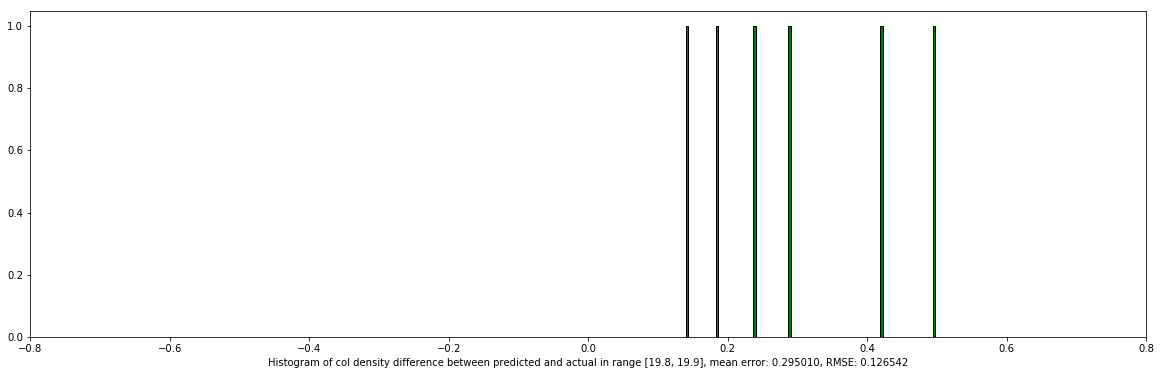

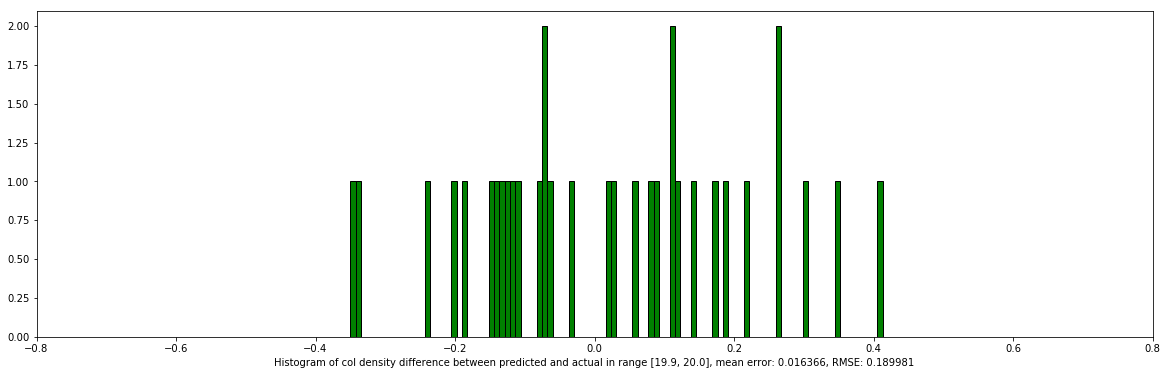

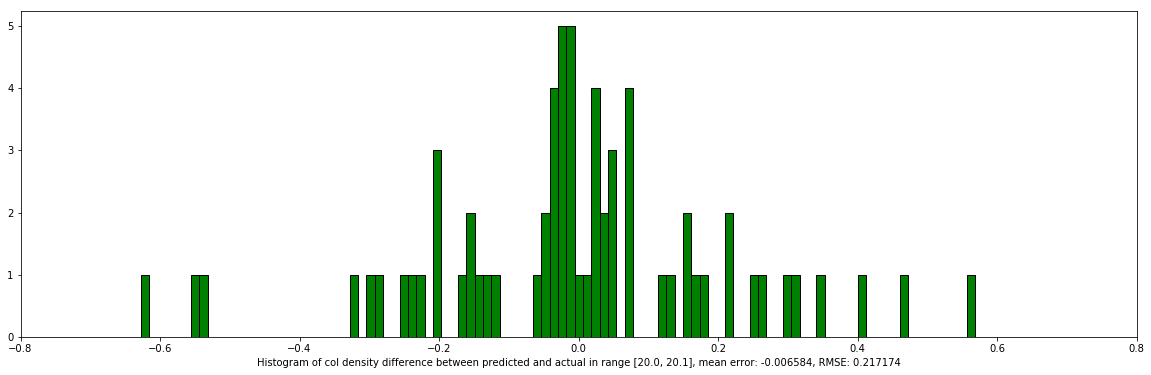

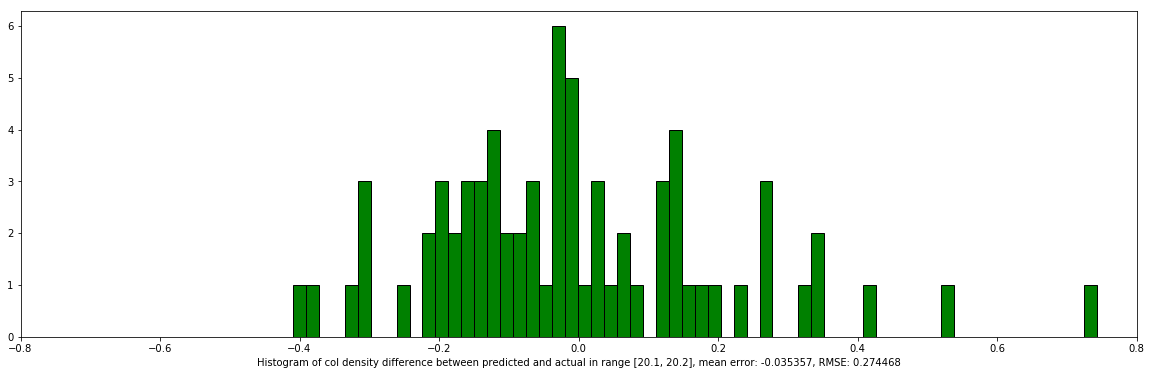

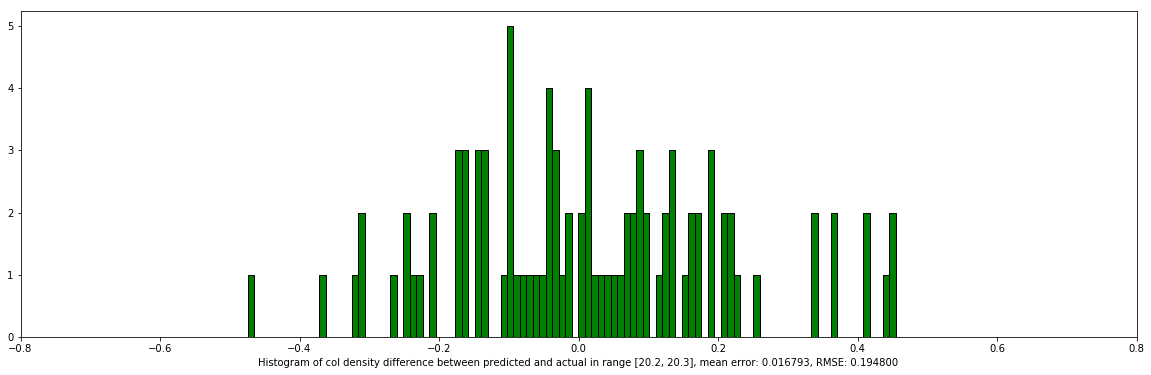

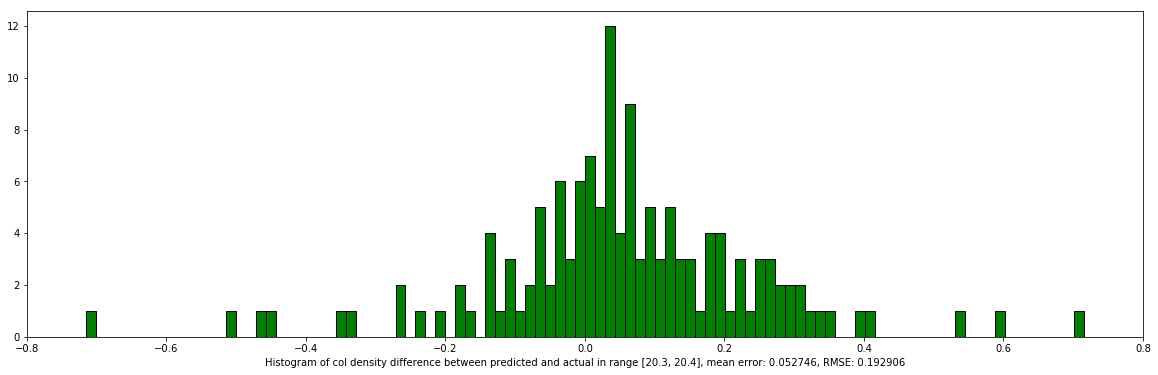

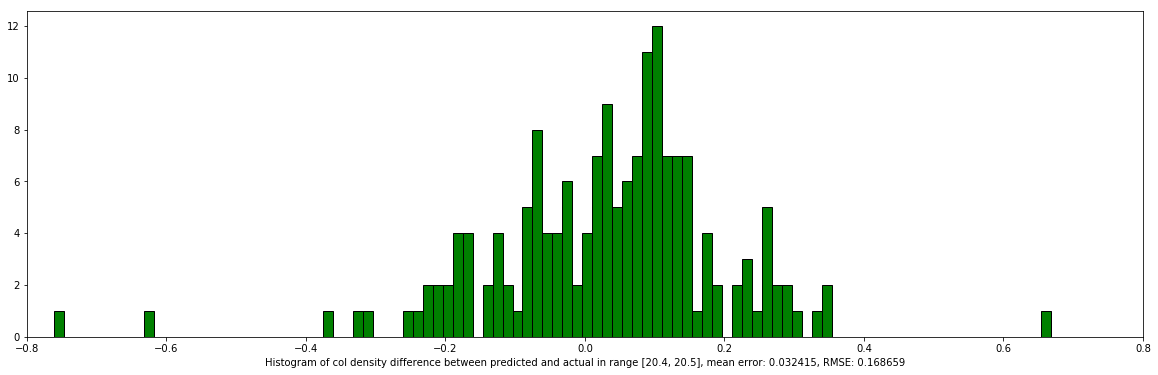

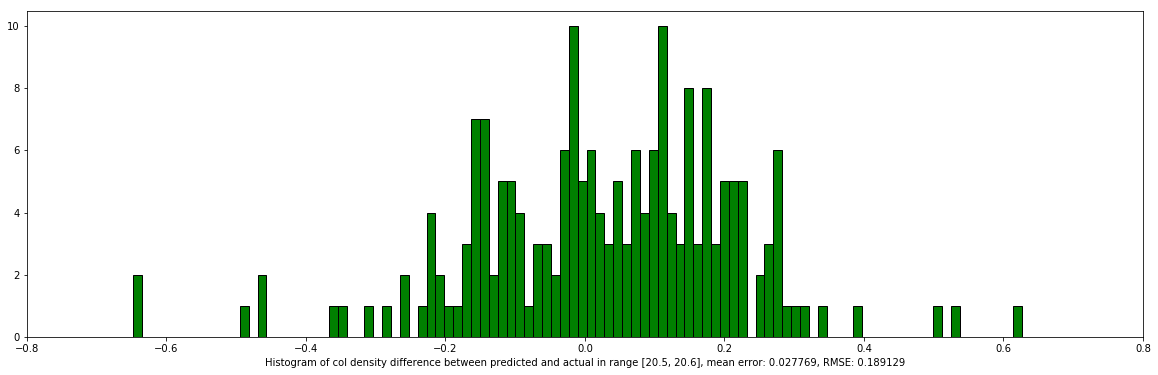

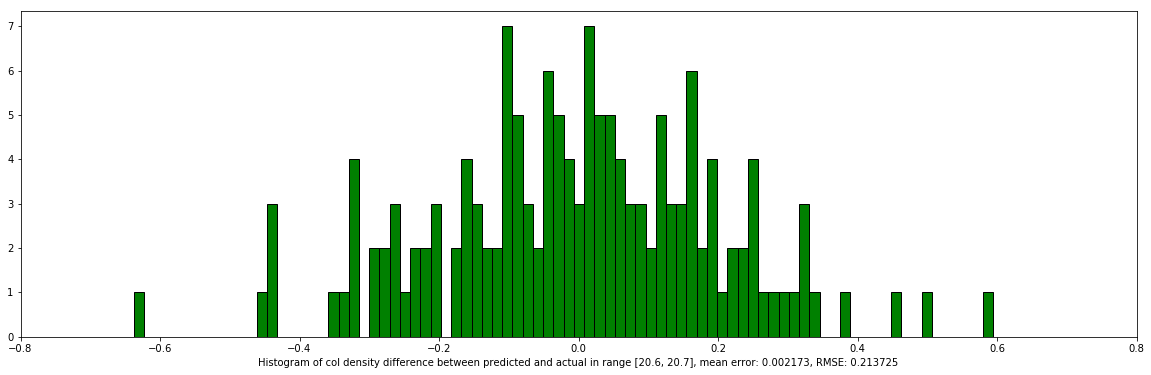

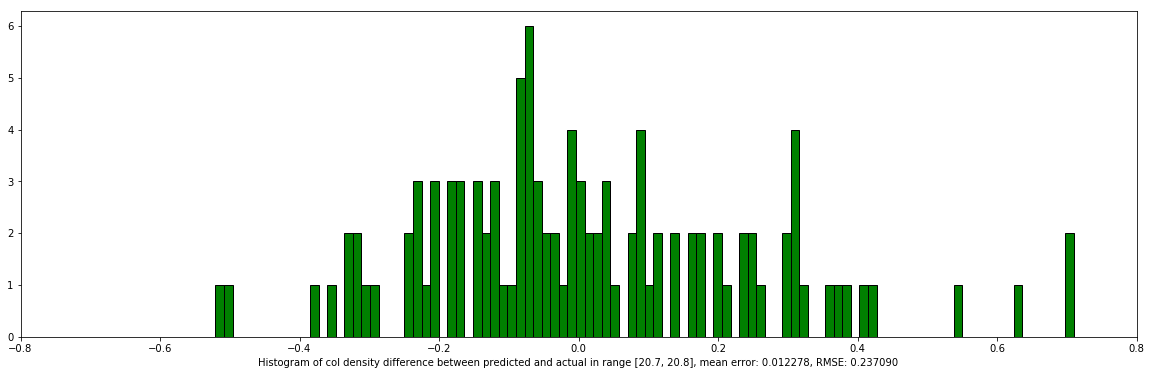

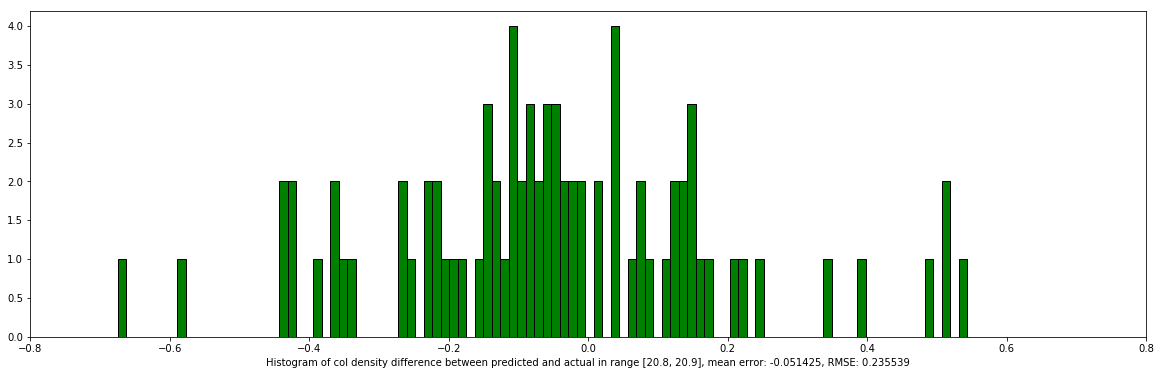

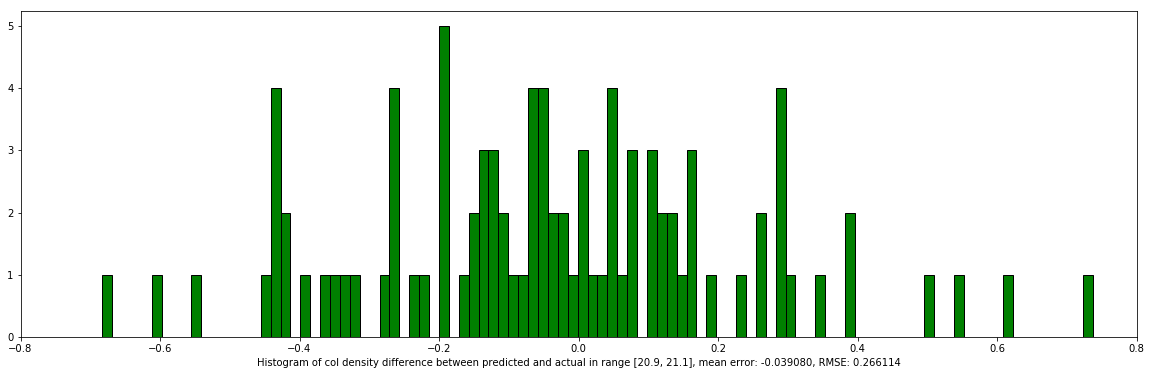

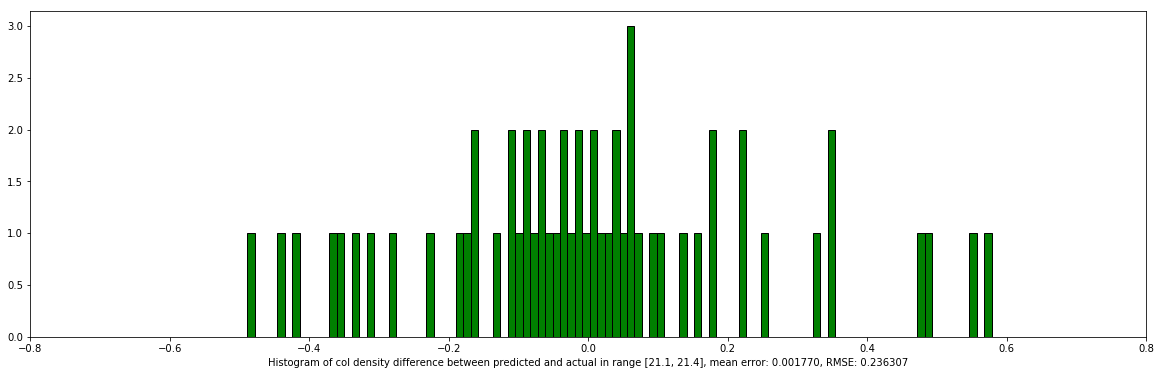

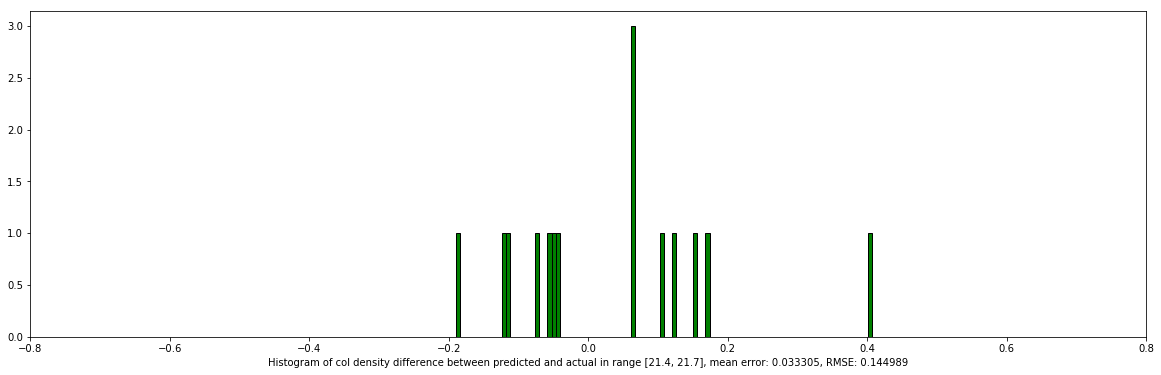

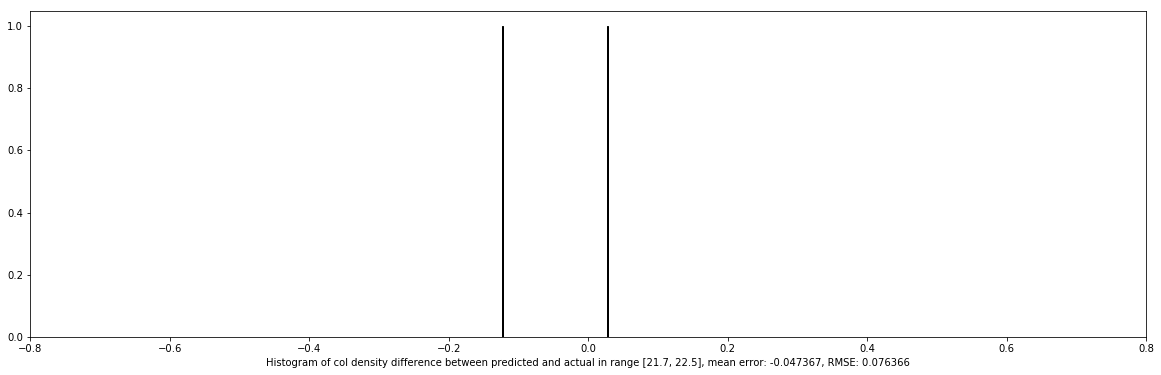

In [56]:
for crange in [[19.2,19.3],
               [19.3,19.4],
               [19.4,19.5],
               [19.5,19.6],
               [19.6,19.7],
               [19.7,19.8],
               [19.8,19.9],
               [19.9,20.0],
               [20.0,20.1],
               [20.1,20.2],
               [20.2,20.3],
               [20.3,20.4],
               [20.4,20.5],
               [20.5,20.6],
               [20.6,20.7],
               [20.7,20.8],
               [20.8,20.9],
               [20.9,21.1],
               [21.1,21.4],
               [21.4,21.7],
               [21.7,22.5]]:
    inrange_coldensity_matrix = all_coldensity_matrix[(all_coldensity_matrix[:,2]>=crange[0])& \
                                                       (all_coldensity_matrix[:,2]<crange[1]),0:2]
    plt.figure(figsize=(20, 6))
    plt.hist(inrange_coldensity_matrix[:,1], 100, facecolor='green', edgecolor='k');
    plt.xlabel(
        "Histogram of col density difference between predicted and actual in range %s, mean error: %06f, RMSE: %06f" \
        % (str(crange), np.mean(inrange_coldensity_matrix[:,1]), np.std(inrange_coldensity_matrix[:,1])))
    plt.xlim([-0.8,0.8])
    print crange, inrange_coldensity_matrix.shape, \
            np.mean(inrange_coldensity_matrix[:,1]), \
            np.std(inrange_coldensity_matrix[:,1])
  
np.set_printoptions(precision=30)
print np.polyfit(all_coldensity_matrix[:,0], all_coldensity_matrix[:,1], 3)
with open('data.txt', 'w') as outfile:
    np.savetxt(outfile, all_coldensity_matrix)

np.set_printoptions(suppress=True)
errors = all_coldensity_matrix[all_coldensity_matrix[:,1].argsort()]
print "\n\nall_coldensity_matrix", "\n", errors[0:3,:], "\n", errors[-3:,:]



# Plot dz vs column density actual (all matching samples)

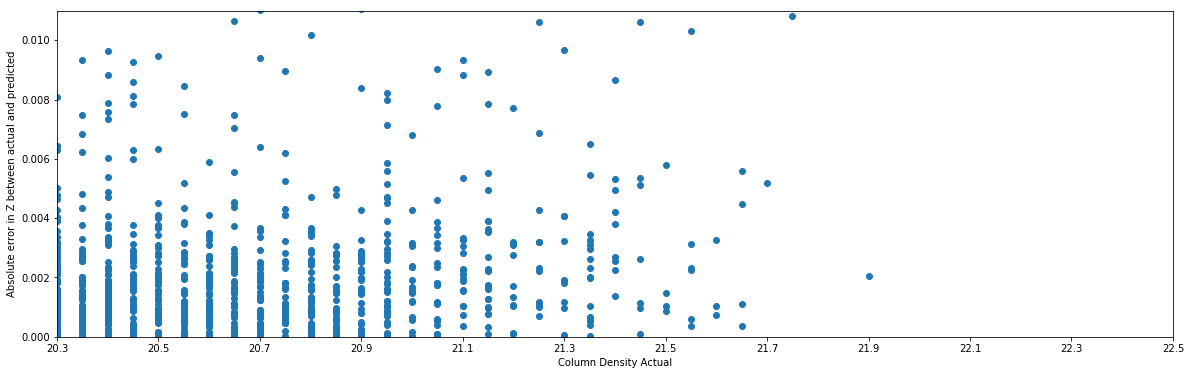

In [57]:
p = np.vstack(all_offset_error)
plt.figure(figsize=(20, 6))
plt.scatter(p[:,0], p[:,1])
plt.xlim([20.3,22.5])
plt.ylim([0,0.011])
plt.xticks([20.3,20.5,20.7,20.9,21.1,21.3,21.5,21.7,21.9,22.1,22.3,22.5])
plt.xlabel("Column Density Actual")
plt.ylabel("Absolute error in Z between actual and predicted")

# Plot column density error vs actual column density (all matching samples)
#Plot 1: X axis: actual column density, Y axis: error from actual
#Plot 2: X axis: predicted column density, Y axis: error from actual

[  -0.016196774248477558560965761103    1.06575890804441253401080302865
  -23.599979330442980796078700223006  175.464317878392478178284363821149]


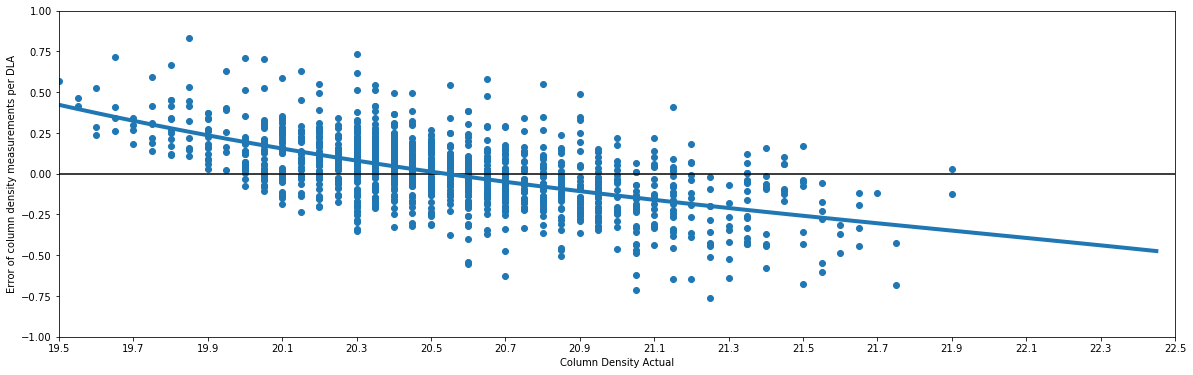

In [58]:
x = all_coldensity_matrix[:,0]
y = all_coldensity_matrix[:,1]

poly_range = np.arange(19.5,22.5,0.05)
poly = np.polyfit(x, y, 3)

plt.figure(figsize=(20, 6))
plt.scatter(x, y)  # 0,1-per actual, 2,3-per predicted
plt.xlim([20.3,22.5])
plt.ylim([-1.0,1.0])
plt.xticks([19.5,19.7,19.9,20.1,20.3,20.5,20.7,20.9,21.1,21.3,21.5,21.7,21.9,22.1,22.3,22.5])
plt.xlabel("Column Density Actual")
plt.ylabel("Error of column density measurements per DLA")
plt.axhline(color="black")

plt.plot(poly_range, np.polyval(poly, poly_range), '-', linewidth=4)
print poly

[    0.116393824413668411921207734849    -7.230812971343802075807616347447
   149.659123179066966713435249403119 -1031.992945011682422773446887731552]


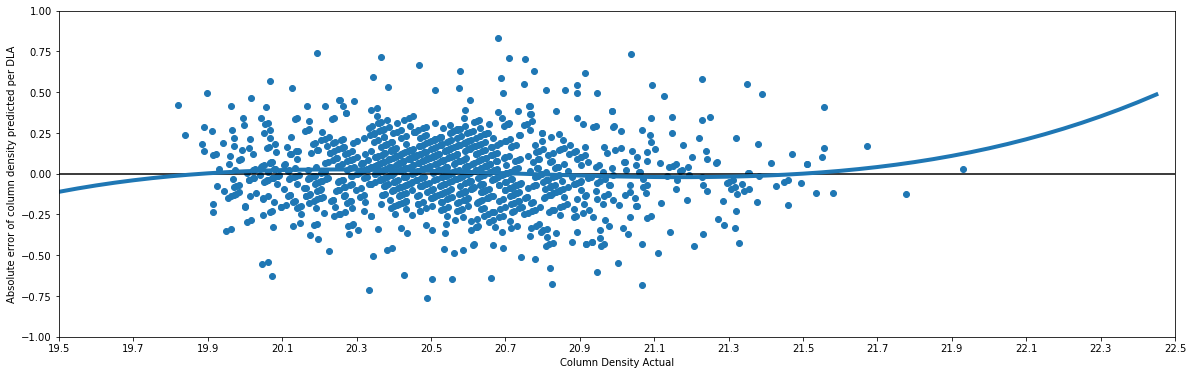

In [59]:
x = all_coldensity_matrix[:,2]
y = all_coldensity_matrix[:,1]

poly_range = np.arange(19.5,22.5,0.05)
poly = np.polyfit(x, y, 3)

plt.figure(figsize=(20, 6))
plt.scatter(x, y)  # 0,1-per actual, 2,3-per predicted
plt.xlim([20.3,22.5])
plt.ylim([-1.0,1.0])
plt.xticks([19.5,19.7,19.9,20.1,20.3,20.5,20.7,20.9,21.1,21.3,21.5,21.7,21.9,22.1,22.3,22.5])
plt.xlabel("Column Density Actual")
plt.ylabel("Absolute error of column density predicted per DLA")
plt.axhline(color="black")

plt.plot(poly_range, np.polyval(poly, poly_range), '-', linewidth=4)
print poly

# Predicted col density vs. Actual
Matching samples based on redshift

[ 1.03327383002014649981958882563  -0.694276768376651087777418069891]


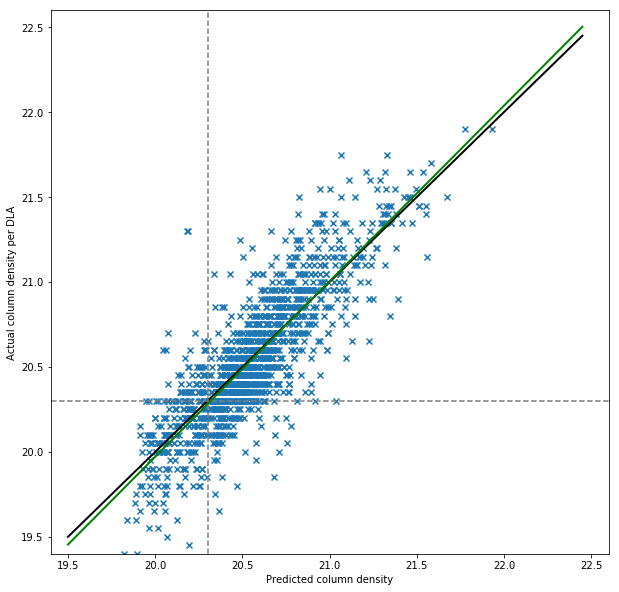

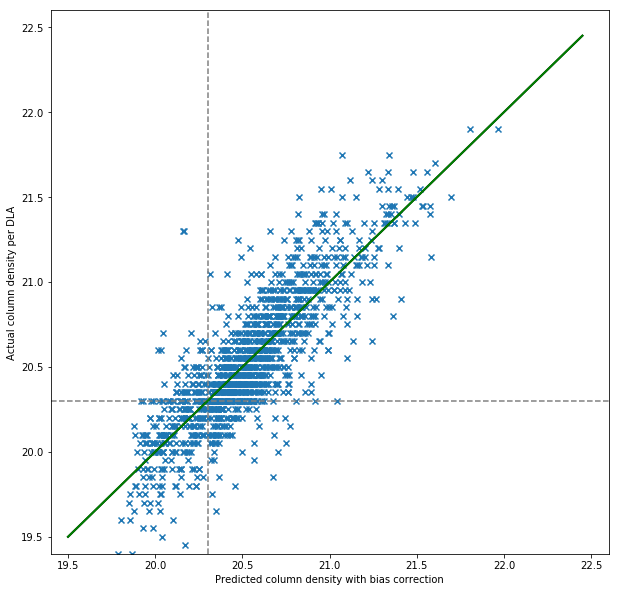

In [60]:
degree = 1

# Predicted X, actual Y
x = all_coldensity_matrix[:,2]
y = all_coldensity_matrix[:,0]
r = np.arange(19.5,22.5,0.05)

plt.figure(figsize=(10, 10))
plt.scatter(x, y, marker="x")  # 0,1-per actual, 2,3-per predicted
plt.xlim([19.4,22.6])
plt.ylim([19.4,22.6])
plt.xlabel("Predicted column density")
plt.ylabel("Actual column density per DLA")
plt.plot(r, r, linewidth=2, color='black')
plt.axvline(20.3, linestyle='--', color='gray')
plt.axhline(20.3, linestyle='--', color='gray')

# Polyfit
p = np.polyfit(x,y,degree)
plt.plot(r, np.polyval(p,r), linewidth=2, color='green')
print p

# Bias correction
x_bias_corrected = np.polyval(p, x)

plt.figure(figsize=(10, 10))
plt.scatter(x_bias_corrected, y, marker="x")  # 0,1-per actual, 2,3-per predicted
plt.xlim([19.4,22.6])
plt.ylim([19.4,22.6])
plt.xlabel("Predicted column density with bias correction")
plt.ylabel("Actual column density per DLA")
plt.plot(r, r, linewidth=2, color='black')
plt.axvline(20.3, linestyle='--', color='gray')
plt.axhline(20.3, linestyle='--', color='gray')

p = np.polyfit(x_bias_corrected,y,degree)
plt.plot(r, np.polyval(p,r), linewidth=2, color='green')


[-0.0007978875154014454258027955191323599137831479310989
  0.0497001705553291109329627772694948362186551094055176
  0.0016421520714977411257301520564055863360408693552017
  6.4415298057628671557495181332342326641082763671875   ]
21.004553934


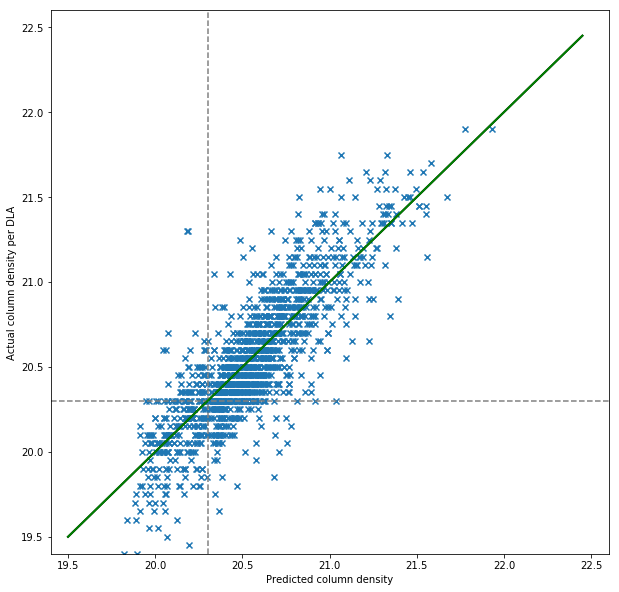

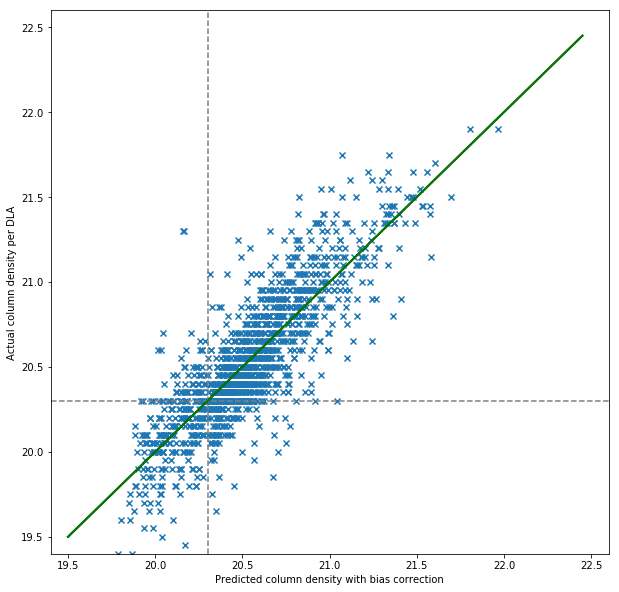

In [61]:
# Ridge regression fit, using X, Y, r from code above
degree = 3
alpha = 1

plt.figure(figsize=(10, 10))
plt.scatter(x, y, marker="x")  # 0,1-per actual, 2,3-per predicted
plt.xlim([19.4,22.6])
plt.ylim([19.4,22.6])
plt.xlabel("Predicted column density")
plt.ylabel("Actual column density per DLA")
plt.plot(r, r, linewidth=2, color='black')
plt.axvline(20.3, linestyle='--', color='gray')
plt.axhline(20.3, linestyle='--', color='gray')

# Ridge regression & plot
# p = np.polyfit(x,y,degree)
model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
model.fit(x.reshape(-1, 1),y)
r_pred = model.predict(r.reshape(-1, 1))
# plt.plot(r, r_pred, linewidth=2, color='green')
plt.plot(r, np.polyval(p,r), linewidth=2, color='green')

# Get polynomial from the model
p = np.flipud(model.get_params()['ridge'].coef_)
p[-1] += model.get_params()['ridge'].intercept_
np.set_printoptions(precision=52)
print p
print np.polyval(p,21.0)

# Bias correction
x_bias_corrected = np.polyval(p, x)

plt.figure(figsize=(10, 10))
plt.scatter(x_bias_corrected, y, marker="x")  # 0,1-per actual, 2,3-per predicted
plt.xlim([19.4,22.6])
plt.ylim([19.4,22.6])
plt.xlabel("Predicted column density with bias correction")
plt.ylabel("Actual column density per DLA")
plt.plot(r, r, linewidth=2, color='black')
plt.axvline(20.3, linestyle='--', color='gray')
plt.axhline(20.3, linestyle='--', color='gray')

p = np.polyfit(x_bias_corrected,y,1)
plt.plot(r, np.polyval(p,r), linewidth=2, color='green')


# Histogram of where False Positives >20.3 are found on the spectrum

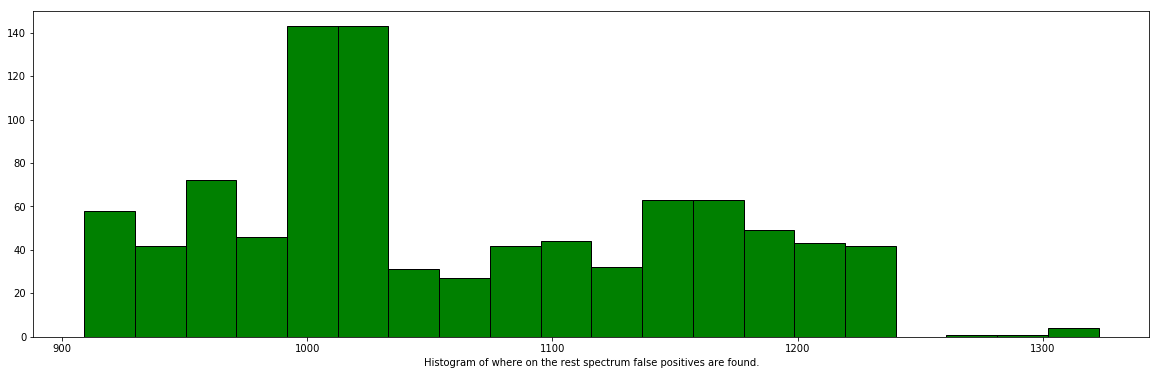

In [62]:
rest_frame_fps = [fp['rest'] for fp in all_false_positives if fp['type'] == 'DLA']
plt.figure(figsize=(20, 6))
plt.hist(rest_frame_fps, 20, facecolor='green', edgecolor='k');
plt.xlabel("Histogram of where on the rest spectrum false positives are found.")

# Scatter plot of where False Positives are found on the spectrum

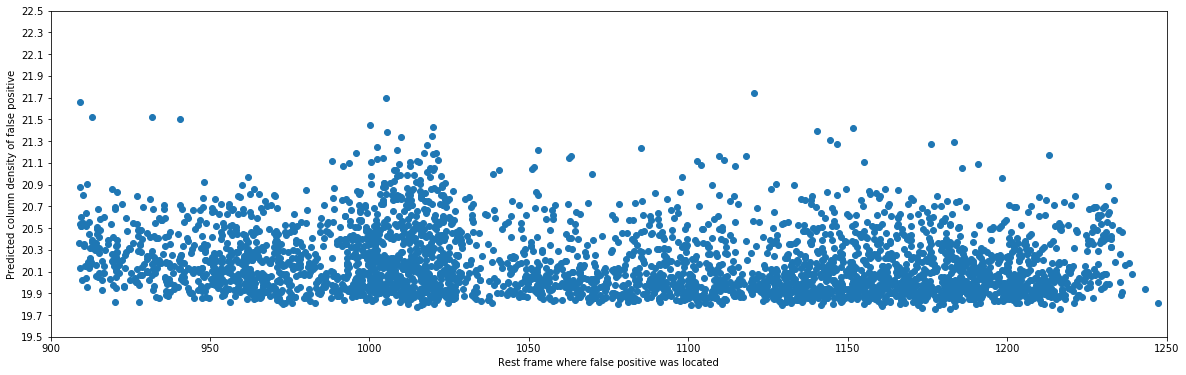

In [63]:
rest_frame_fps = [fp['rest'] for fp in all_false_positives]
col_density_fps = [fp['column_density'] for fp in all_false_positives]

plt.figure(figsize=(20, 6))
plt.scatter(rest_frame_fps, col_density_fps)
plt.xlim([900,1250])
plt.yticks([19.5,19.7,19.9,20.1,20.3,20.5,20.7,20.9,21.1,21.3,21.5,21.7,21.9,22.1,22.3,22.5])
plt.xlabel("Rest frame where false positive was located")
plt.ylabel("Predicted column density of false positive")

# False positives histogram by column density

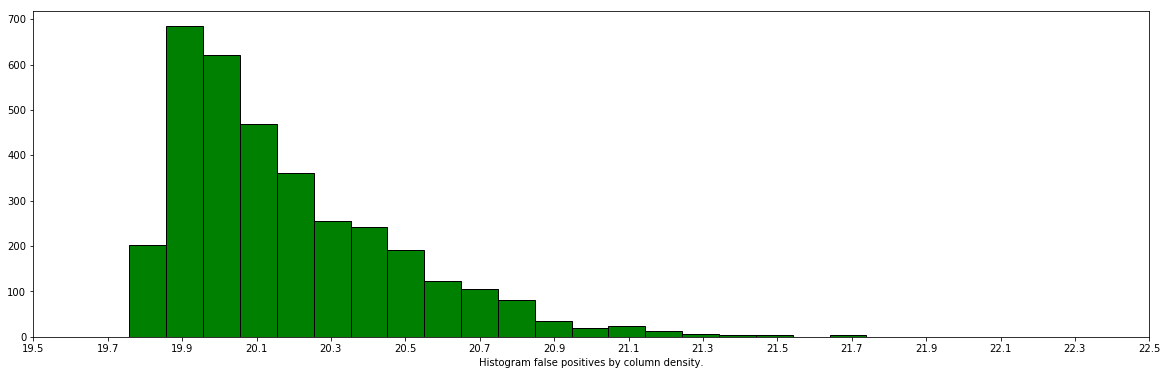

In [64]:
col_density_fps = [fp['column_density'] for fp in all_false_positives]
plt.figure(figsize=(20, 6))
plt.hist(col_density_fps, 20, facecolor='green', edgecolor='k');
plt.xlabel("Histogram false positives by column density.")
plt.xticks([19.5,19.7,19.9,20.1,20.3,20.5,20.7,20.9,21.1,21.3,21.5,21.7,21.9,22.1,22.3,22.5]);

# False negatives histogram by column density 

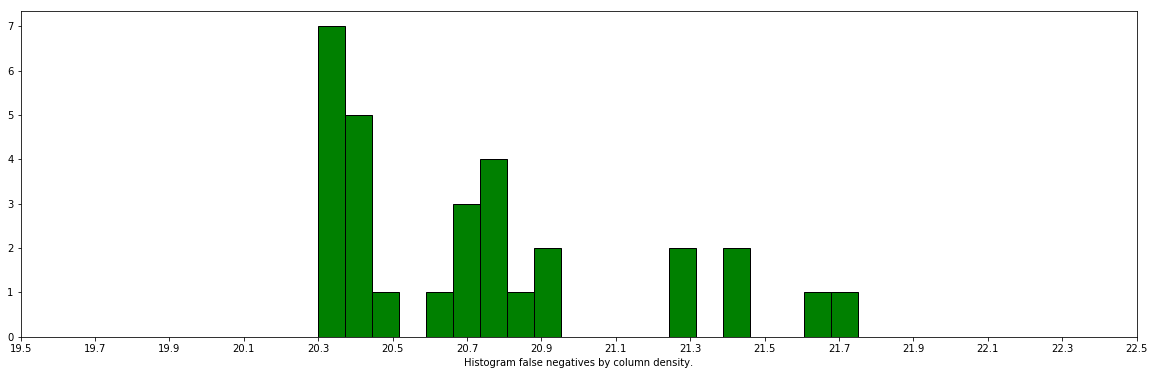

In [65]:
col_density_fps = [fn['NHI'] for fn in all_false_negatives]
plt.figure(figsize=(20, 6))
plt.hist(col_density_fps, 20, facecolor='green', edgecolor='k');
plt.xlabel("Histogram false negatives by column density.")
plt.xticks([19.5,19.7,19.9,20.1,20.3,20.5,20.7,20.9,21.1,21.3,21.5,21.7,21.9,22.1,22.3,22.5]);

# Confidence for False Positives vs confidence of correct DLAs

(0, 80)

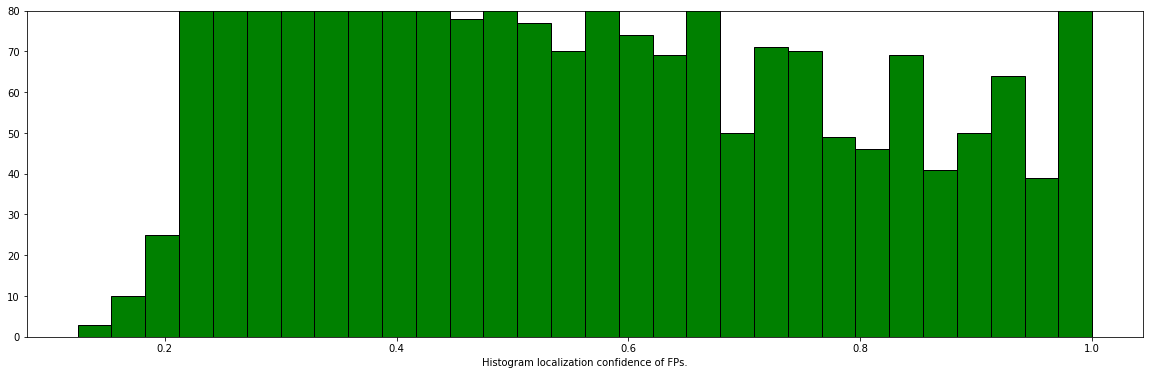

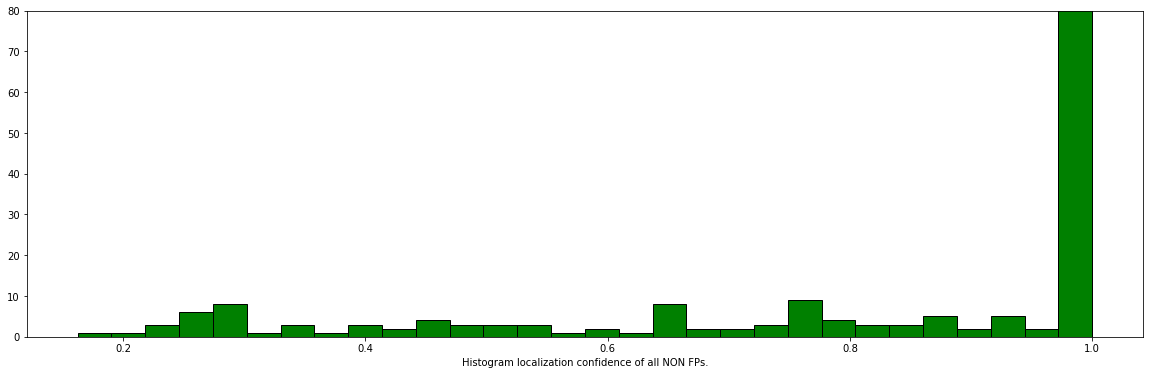

In [66]:
fps_dla_conf = [dla['dla_confidence'] for dla in all_false_positives]
fps_dla_ids = [dla['id'] for dla in all_false_positives]
all_nonfps_dlas = [psub for p in predictions if p['id'] not in fps_dla_ids for psub in p['dlas']]
all_nonfps_conf = [d['dla_confidence'] for d in all_nonfps_dlas]

plt.figure(figsize=(20, 6))
plt.hist(fps_dla_conf, 30, facecolor='green', edgecolor='k');
plt.xlabel("Histogram localization confidence of FPs.")
plt.ylim([0,80])

plt.figure(figsize=(20, 6))
plt.hist(all_nonfps_conf, 30, facecolor='green', edgecolor='k');
plt.xlabel("Histogram localization confidence of all NON FPs.")
plt.ylim([0,80])


# Display False Positives list

In [67]:
print json.dumps(all_false_positives, indent=1)

[
 {
  "std_column_density": 0.10119874775409698, 
  "column_density": 19.87682321073392, 
  "spectrum": 3922.8346253952054, 
  "rest": 1192.1303214659763, 
  "column_density_bias_adjust": 0.22905519010403808, 
  "dla_confidence": 0.8250000000000001, 
  "z_qso": 2.2906088829040527, 
  "type": "SUBDLA", 
  "id": "00272-00195", 
  "z_dla": 2.2268910357212115
 }, 
 {
  "std_column_density": 0.06558240205049515, 
  "column_density": 19.923748657676377, 
  "spectrum": 4438.12980308139, 
  "rest": 947.5445228544902, 
  "column_density_bias_adjust": 0.2110811924664162, 
  "dla_confidence": 0.6, 
  "z_qso": 3.6838219165802, 
  "type": "SUBDLA", 
  "id": "00273-00037", 
  "z_dla": 2.6507685499201177
 }, 
 {
  "std_column_density": 0.05532049760222435, 
  "column_density": 19.88664302333016, 
  "spectrum": 5022.269341823904, 
  "rest": 1072.2588158285093, 
  "column_density_bias_adjust": 0.22519549830574448, 
  "dla_confidence": 1.0, 
  "z_qso": 3.6838219165802, 
  "type": "SUBDLA", 
  "id": "00

In [68]:
# FP DLAs only
fp_gt_203 = [(fp['id'], fp['z_dla'], fp['z_qso'], fp['column_density'], fp['std_column_density'], fp['type']) for fp in all_false_positives if fp['type'] == 'DLA']
print len(fp_gt_203)
print json.dumps(fp_gt_203, indent=1)

946
[
 [
  "00278-00215", 
  3.846009939617999, 
  4.575846195220947, 
  20.341142546403628, 
  0.08631671220064163, 
  "DLA"
 ], 
 [
  "00278-00215", 
  4.022087793842917, 
  4.575846195220947, 
  20.48335638790899, 
  0.11000795662403107, 
  "DLA"
 ], 
 [
  "00278-00215", 
  4.297662664503127, 
  4.575846195220947, 
  20.468918351798795, 
  0.18707787990570068, 
  "DLA"
 ], 
 [
  "00278-00215", 
  4.424807110066752, 
  4.575846195220947, 
  20.627211167117167, 
  0.058402519673109055, 
  "DLA"
 ], 
 [
  "00280-00447", 
  3.653549100311545, 
  4.581201076507568, 
  20.46898324130723, 
  0.06076538562774658, 
  "DLA"
 ], 
 [
  "00282-00535", 
  2.667619731901508, 
  3.4343531131744385, 
  20.58627751936205, 
  0.07612971216440201, 
  "DLA"
 ], 
 [
  "00283-00240", 
  2.2982555399715343, 
  2.900386095046997, 
  20.48443074744515, 
  0.13764159381389618, 
  "DLA"
 ], 
 [
  "00286-00183", 
  3.6439154123239836, 
  5.031899929046631, 
  20.593006083710332, 
  0.15275844931602478, 
  "DLA"

# Display False Negatives list

In [69]:
print json.dumps(sorted(all_false_negatives, key=itemgetter('id')), indent=1)

[
 {
  "zabs": 4.6743, 
  "NHI": 20.7, 
  "id": 72, 
  "sl": "00286-00183"
 }, 
 {
  "zabs": 2.2213, 
  "NHI": 20.4, 
  "id": 836, 
  "sl": "00493-00507"
 }, 
 {
  "zabs": 4.2545, 
  "NHI": 20.3, 
  "id": 841, 
  "sl": "00494-00542"
 }, 
 {
  "zabs": 3.2855, 
  "NHI": 20.7, 
  "id": 954, 
  "sl": "00517-00259"
 }, 
 {
  "zabs": 2.2553, 
  "NHI": 20.35, 
  "id": 1090, 
  "sl": "00548-00294"
 }, 
 {
  "zabs": 2.2005, 
  "NHI": 20.8, 
  "id": 1545, 
  "sl": "00627-00155"
 }, 
 {
  "zabs": 3.4523, 
  "NHI": 21.65, 
  "id": 1901, 
  "sl": "00751-00039"
 }, 
 {
  "zabs": 4.3175, 
  "NHI": 20.5, 
  "id": 1908, 
  "sl": "00752-00378"
 }, 
 {
  "zabs": 3.7789, 
  "NHI": 21.75, 
  "id": 2154, 
  "sl": "00787-00048"
 }, 
 {
  "zabs": 4.3034, 
  "NHI": 20.35, 
  "id": 2312, 
  "sl": "00826-00305"
 }, 
 {
  "zabs": 3.6415, 
  "NHI": 20.3, 
  "id": 2469, 
  "sl": "00849-00584"
 }, 
 {
  "zabs": 2.9052, 
  "NHI": 20.3, 
  "id": 3724, 
  "sl": "01162-00579"
 }, 
 {
  "zabs": 2.2372, 
  "NHI": 21.3, 
 

# DR5 specific: check range of false positives


In [70]:
if results_file.find("data_dr5") > 0:
    np.set_printoptions(precision=3)
#     dr5range = np.loadtxt(base_dir + '/results/dr5_sightlines_for_david.ascii')
    dr5range = np.loadtxt(base_dir + '/data/dr5_sightline_human_analysis_range.ascii')
    dr5groundtruth = np.loadtxt(base_dir + '/data/dr5_ground_truth_with_slls.ascii') #plate,fiber,z_dla,coldensity
    # print dr5groundtruth[0:2]
    count = 0
    fp_203 = [fp for fp in all_false_positives if fp['type'] == 'DLA']# and fp['id'] == "00410-00466"]

    for fp in fp_203:
        m = re.search('(\d+)-(\d+)', fp['id'])
        plate, fiber = m.group(1), m.group(2)
        # range of the sightline that was inspected by human experts
        actual = dr5range[(dr5range[:,0].astype(np.int) == int(plate)) & (dr5range[:,1].astype(np.int) == int(fiber))]

        # Merge DLAs from ground truth file with range file (so we can show the actual vs. predicted column density)
        dlas_actual = dr5groundtruth[(dr5groundtruth[:,0].astype(np.int) == int(plate)) & (dr5groundtruth[:,1].astype(np.int) == int(fiber))]
        dla_nearest = [] if len(dlas_actual)==0 else dlas_actual[np.argmin(np.abs(fp['z_dla'] - dlas_actual[:,3]))]

#         print fp
#         print dlas_actual
#         print dla_nearest
#         print "\n\n"
        
        # Print results, which FPs were in the range that humans analyzed and which weren't
        assert len(actual) == 1
        in_range = fp['z_dla'] > actual[0,2] and fp['z_dla'] < actual[0,3]
        count += 1 if in_range else 0
        print ("%s\t%0.3f\t%0.3f\t%0.3f\tplate/fiber:\t%s\t%s\t"+
               "pred. z/cd\t%0.3f\t%0.3f\tnearest actual dla\t%0.3f\t%0.3f\tdiff\t%0.3f") % \
        (in_range, fp['z_dla'], actual[0,2], actual[0,3], plate, fiber, fp['z_dla'], fp['column_density'], \
         0.0 if len(dlas_actual)==0 else dla_nearest[3], 0.0 if len(dlas_actual)==0 else  dla_nearest[2], \
         0.0 if len(dlas_actual)==0 else abs(fp['z_dla'] - dla_nearest[3]))

    print "\ntotal FPs > 20.3 ",len(fp_203)
    print count, "fp's in range, ", len(fp_203) - count, " outside range. "


True	3.846	3.438	4.510	plate/fiber:	00278	00215	pred. z/cd	3.846	20.341	nearest actual dla	0.000	0.000	diff	0.000
True	4.022	3.438	4.510	plate/fiber:	00278	00215	pred. z/cd	4.022	20.483	nearest actual dla	0.000	0.000	diff	0.000
True	4.298	3.438	4.510	plate/fiber:	00278	00215	pred. z/cd	4.298	20.469	nearest actual dla	0.000	0.000	diff	0.000
True	4.425	3.438	4.510	plate/fiber:	00278	00215	pred. z/cd	4.425	20.627	nearest actual dla	0.000	0.000	diff	0.000
False	3.654	3.874	4.496	plate/fiber:	00280	00447	pred. z/cd	3.654	20.469	nearest actual dla	0.000	0.000	diff	0.000
True	2.668	2.230	3.384	plate/fiber:	00282	00535	pred. z/cd	2.668	20.586	nearest actual dla	2.362	19.900	diff	0.305
False	2.298	2.860	2.881	plate/fiber:	00283	00240	pred. z/cd	2.298	20.484	nearest actual dla	0.000	0.000	diff	0.000
False	3.644	4.296	4.972	plate/fiber:	00286	00183	pred. z/cd	3.644	20.593	nearest actual dla	4.674	20.700	diff	1.030
False	2.659	2.242	2.627	plate/fiber:	00286	00598	pred. z/cd	2.659	20.360	nearest ac

# 10k96629 specific: check range of false positives

In [71]:
if results_file.find("data_testdlas10k96629") > 0:
    table_ix96629_plate_fiber = "../../data/table_ix96629_plate_fiber.csv"
    table_ixs = np.loadtxt(table_ix96629_plate_fiber, skiprows=1, delimiter=',')

    print "fp_ix fp_plate fp_fiber fp_ra fp_dec fp_z_dla fp_z_start fp_z_end is_in_range"

    for fp in fp_gt_203:
    #     print fp
        fp_ix = int(fp[0][25:])
        table_entry = table_ixs[table_ixs[:,0].astype(np.int) == fp_ix]
        assert len(table_entry) == 1
    #     print table_entry

        fp_z_dla = fp[1]
        fp_plate = table_entry[0][1]
        fp_fiber = table_entry[0][2]
        fp_ra = table_entry[0][5]
        fp_dec = table_entry[0][6]
        fp_z_start = table_entry[0][3]
        fp_z_end = table_entry[0][4]
        is_in_range = fp_z_dla >= fp_z_start and fp_z_dla <= fp_z_end

        print fp_ix, fp_plate, fp_fiber, fp_ra, fp_dec, fp_z_dla, fp_z_start, fp_z_end, is_in_range
    #     break
